In [2]:
import pandas as pd 
import numpy as np 

# Read Data and look at the dataframes


In [3]:
dir_path = "../ml_data/ml-latest-small/"
movies_df = pd.read_csv(dir_path+'movies.csv')
tags_df  = pd.read_csv(dir_path+'tags.csv')
ratings_df = pd.read_csv(dir_path+'ratings.csv')
links_df = pd.read_csv(dir_path+'links.csv')


In [4]:
print(f"movies: {movies_df.shape}")
print(f"tags: {tags_df.shape}")
print(f"ratings: {ratings_df.shape}")
print(f"links: {links_df.shape}")

movies: (9742, 3)
tags: (3683, 4)
ratings: (100836, 4)
links: (9742, 3)


In [5]:
print(f"movies: {movies_df.columns}")
print(f"tags: {tags_df.columns}")
print(f"ratings: {ratings_df.columns}")
print(f"links: {links_df.columns}")

movies: Index(['movieId', 'title', 'genres'], dtype='object')
tags: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
ratings: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


In [6]:
print(movies_df.head(5))


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [7]:
print(f"Tags\n {tags_df.head(5)}")
print(f"Ratings\n {ratings_df.head(5)}")
print(f"Links\n {links_df.head(5)}")

Tags
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200
Ratings
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Links
    movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0


# Some EDA for the KNN Approach


In [8]:
import matplotlib.pyplot as plt

In [9]:
display((ratings_df.query('rating == 4.0')).count())

userId       26818
movieId      26818
rating       26818
timestamp    26818
dtype: int64

In [10]:
#Get the count of the different ratings
ratings_df.groupby('rating').count()['userId'].plot.bar()
plt.title("Count of the ratings")
plt.ylabel("count")
plt.xlabel("rating")
plt.show()

 Since the bias is important we dont oversample the test set in the future


userId  rating   timestamp             title
movieId                                              
1             1     4.0   964982703  Toy Story (1995)
1             5     4.0   847434962  Toy Story (1995)
1             7     4.5  1106635946  Toy Story (1995)
1            15     2.5  1510577970  Toy Story (1995)
1            17     4.5  1305696483  Toy Story (1995)

userId  rating  timestamp
title                                                      
Forrest Gump (1994)                  329     329        329
Shawshank Redemption, The (1994)     317     317        317
Pulp Fiction (1994)                  307     307        307
Silence of the Lambs, The (1991)     279     279        279
Matrix, The (1999)                   278     278        278

<AxesSubplot:xlabel='title'>

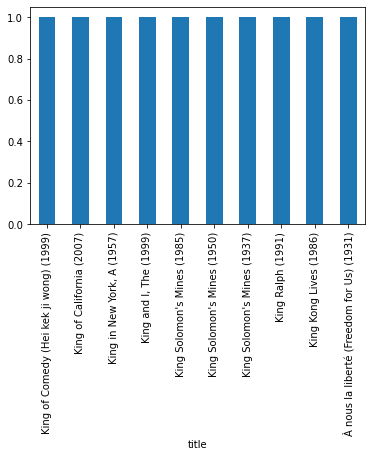

In [11]:
#join dataframes to get movie title
joined_df  = ratings_df.set_index('movieId').join(movies_df[['movieId','title']].set_index('movieId'), )
#sort to most ratet movies
display(joined_df.head(5))

sorted_df = joined_df.groupby('title').count().sort_values(['rating'], ascending=False).head(5)

display(sorted_df.head(5))

#display the most 10 ratet movies
joined_df.groupby('title').count().sort_values(['rating'], ascending=False)[-10:]['rating'].plot.bar()


Every movie is rated at least once

In [12]:
display(movies_df.head(5))
temp_movies = movies_df.copy()
temp_movies.genres = temp_movies.genres.str.split("|").tolist()

temp_movies.head(5)
#len(set(list(chain(*movies_df.genres.str.split("|").tolist()))))


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output=True)

movies_encoded = temp_movies.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(temp_movies.pop('genres')),
                index=temp_movies.index,
                columns=mlb.classes_))
display(movies_encoded.query('movieId == 168250'))


movieId           title  (no genres listed)  Action  Adventure  \
9462   168250  Get Out (2017)                   0       0          0   

      Animation  Children  Comedy  Crime  Documentary  ...  Film-Noir  Horror  \
9462          0         0       0      0            0  ...          0       1   

      IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
9462     0        0        0        0       0         0    0        0  

[1 rows x 22 columns]

In [14]:
#genres = set(list(chain(*movies_df.genres.str.split("|").tolist())))
#list_genres = list(genres)
#columns = list_genres.append('movieId')
#print(list_genres)

ratings_with_genres  = ratings_df.copy().merge(movies_encoded, how = 'left', left_on= 'movieId', right_on= 'movieId')
display(ratings_with_genres)
#Use this line to remove duplicate movieId
#del ratings_with_genres['movieId_original']
#display(ratings_with_genres)

userId  movieId  rating   timestamp                           title  \
0            1        1     4.0   964982703                Toy Story (1995)   
1            1        3     4.0   964981247         Grumpier Old Men (1995)   
2            1        6     4.0   964982224                     Heat (1995)   
3            1       47     5.0   964983815     Seven (a.k.a. Se7en) (1995)   
4            1       50     5.0   964982931      Usual Suspects, The (1995)   
...        ...      ...     ...         ...                             ...   
100831     610   166534     4.0  1493848402                    Split (2017)   
100832     610   168248     5.0  1493850091   John Wick: Chapter Two (2017)   
100833     610   168250     5.0  1494273047                  Get Out (2017)   
100834     610   168252     5.0  1493846352                    Logan (2017)   
100835     610   170875     3.0  1493846415  The Fate of the Furious (2017)   

        (no genres listed)  Action  Adventure  Animation  Children  ...  \
0                        0       0          1          1         1  ...   
1                        0       0          0          0         0  ...   
2                        0       1          0          0         0  ...   
3                        0       0          0          0         0  ...   
4                        0       0          0          0         0  ...   
...                    ...     ...        ...        ...       ...  ...   
100831                   0       0          0          0         0  ...   
100832                   0       1          0          0         0  ...   
100833                   0       0          0          0         0  ...   
100834                   0       1          0          0         0  ...   
100835                   0       1          0          0         0  ...   

        Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  \
0               0       0     0        0        0        0       0         0   
1               0       0     0        0        0        1       0         0   
2               0       0     0        0        0        0       0         1   
3               0       0     0        0        1        0       0         1   
4               0       0     0        0        1        0       0         1   
...           ...     ...   ...      ...      ...      ...     ...       ...   
100831          0       1     0        0        0        0       0         1   
100832          0       0     0        0        0        0       0         1   
100833          0       1     0        0        0        0       0         0   
100834          0       0     0        0        0        0       1         0   
100835          0       0     0        0        0        0       0         1   

        War  Western  
0         0        0  
1         0        0  
2         0        0  
3         0        0  
4         0        0  
...     ...      ...  
100831    0        0  
100832    0        0  
100833    0        0  
100834    0        0  
100835    0        0  

[100836 rows x 25 columns]

# Modeling with KNN

In [15]:
#!pip install scikit-surprise
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise.model_selection import KFold
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import GridSearchCV

# Modeling with surprise KNN

In [16]:
reader  = Reader(rating_scale=(0,5))

data  = Dataset.load_from_df(ratings_df[['userId','movieId','rating']], reader)
anti_set = data.build_full_trainset().build_anti_testset()
#print(anti_set)
#anti set is a set of movies a user hasnt ratet yet


In [17]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=0)


In [79]:
#testing for myself
sim_options = {'name': 'pearson', 'user_based' : False}
model  = KNNBaseline(sim_options=sim_options, k=200)
model.fit(trainset)
predictions = model.test(testset)
rmse = accuracy.rmse(predictions, verbose=True)
print(rmse)


Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8667
0.8667408119448309


# Grid Search to find the best KNN estimator (12 Hours)

In [80]:
#KNNBasic
estimator_list = [ (KNNBasic,'KNNBasic'),(KNNBaseline,'KNNBaseline')] #,(KNNWithMeans,'KNNWithMeans'), (KNNWithZScore,'KNNZScore')
best_estimator_dict = {}
for estimator, estimator_name in estimator_list:
    if estimator_name == 'KNNBaseline':
        
        param_grid = {

        'sim_options' : {'name' :  ['pearson_baseline'],
        'user_based': [True, False] ,
        'shrinkage' : [100,150, 200]}, 
        'k'  : [50,55,60,65],
        }

    else:
       
        param_grid = {

            'sim_options' : {'name' :  ['pearson'],
            'user_based': [True, False]} ,
            'k'  : [50,55,60,65],
        }

    gs = GridSearchCV(estimator, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1, joblib_verbose=10, refit=True, return_train_measures=True)
    gs.fit(data)
    results_df = pd.DataFrame.from_dict(gs.cv_results)
    display(results_df.sort_values(by=["rank_test_rmse"], axis=0, ascending=True))
    best_estimator_dict[estimator_name] = gs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  9.0min remaining:   28.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.0min finished


Computing the pearson similarity matrix...
Done computing similarity matrix.


split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
7          0.959634           0.683276          0.963278           0.684107   
6          0.960647           0.682998          0.964113           0.683848   
5          0.962044           0.682935          0.965658           0.683695   
4          0.963500           0.682753          0.967006           0.683384   
2          0.969275           0.665737          0.968654           0.666678   
3          0.969319           0.666454          0.968645           0.667441   
1          0.969292           0.664768          0.968691           0.665724   
0          0.969322           0.663557          0.968658           0.664516   

   split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
7          0.955730           0.687610          0.969145           0.684403   
6          0.956811           0.687526          0.970081           0.684350   
5          0.958162           0.687509          0.971475           0.684334   
4          0.960148           0.687495          0.972830           0.684279   
2          0.976407           0.668433          0.982791           0.663101   
3          0.976407           0.669224          0.982747           0.663799   
1          0.976376           0.667422          0.982789           0.662157   
0          0.976459           0.666111          0.982793           0.660873   

   split4_test_rmse  split4_train_rmse  ...  mean_train_mae  std_train_mae  \
7          0.965636           0.685243  ...        0.524047       0.001210   
6          0.966722           0.685237  ...        0.523985       0.001263   
5          0.967836           0.685070  ...        0.523966       0.001262   
4          0.969259           0.684790  ...        0.523855       0.001336   
2          0.972494           0.665145  ...        0.497544       0.001541   
3          0.972534           0.665866  ...        0.498104       0.001564   
1          0.972544           0.664124  ...        0.496808       0.001516   
0          0.972559           0.662793  ...        0.495878       0.001509   

   rank_test_mae  mean_fit_time  std_fit_time  mean_test_time  std_test_time  \
7              1      37.202773      5.126738        9.238107       1.110660   
6              2      39.897952      5.727076        9.163365       1.058976   
5              3      51.510427      9.359284        8.686366       0.505112   
4              4      82.015231     17.559488        8.537948       1.028564   
2              6       0.881241      0.025383        1.748144       0.054736   
3              7       0.820567      0.029020        1.610756       0.103590   
1              5       1.017055      0.085469        1.614884       0.109408   
0              8       0.860381      0.143569        1.508291       0.043468   

                                              params  \
7  {'sim_options': {'name': 'pearson', 'user_base...   
6  {'sim_options': {'name': 'pearson', 'user_base...   
5  {'sim_options': {'name': 'pearson', 'user_base...   
4  {'sim_options': {'name': 'pearson', 'user_base...   
2  {'sim_options': {'name': 'pearson', 'user_base...   
3  {'sim_options': {'name': 'pearson', 'user_base...   
1  {'sim_options': {'name': 'pearson', 'user_base...   
0  {'sim_options': {'name': 'pearson', 'user_base...   

                          param_sim_options  param_k  
7  {'name': 'pearson', 'user_based': False}       65  
6  {'name': 'pearson', 'user_based': False}       60  
5  {'name': 'pearson', 'user_based': False}       55  
4  {'name': 'pearson', 'user_based': False}       50  
2   {'name': 'pearson', 'user_based': True}       60  
3   {'name': 'pearson', 'user_based': True}       65  
1   {'name': 'pearson', 'user_based': True}       55  
0   {'name': 'pearson', 'user_based': True}       50  

[8 rows x 37 columns]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 19.0min finished


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
21          0.839145           0.235634          0.864680           0.235530   
20          0.839155           0.231058          0.864853           0.230898   
22          0.839340           0.239602          0.864703           0.239517   
23          0.839426           0.243220          0.864749           0.243053   
17          0.839277           0.261478          0.864787           0.261186   
16          0.839399           0.256950          0.864954           0.256607   
18          0.839526           0.265434          0.864868           0.265117   
19          0.839614           0.268951          0.864857           0.268581   
13          0.839557           0.295271          0.864965           0.294642   
12          0.839695           0.290870          0.865153           0.290225   
14          0.839767           0.299035          0.865084           0.298392   
15          0.839896           0.302385          0.865038           0.301695   
0           0.871607           0.289100          0.887485           0.287507   
1           0.871640           0.289760          0.887506           0.288185   
2           0.871677           0.290230          0.887557           0.288671   
3           0.871683           0.290565          0.887592           0.289013   
4           0.871713           0.256609          0.887561           0.255479   
5           0.871739           0.257289          0.887604           0.256159   
6           0.871776           0.257755          0.887634           0.256642   
7           0.871797           0.258102          0.887669           0.256984   
8           0.871844           0.232280          0.887680           0.231460   
9           0.871874           0.232955          0.887724           0.232134   
10          0.871907           0.233424          0.887743           0.232616   
11          0.871927           0.233761          0.887783           0.232949   

    split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
21          0.851685           0.236061          0.852630           0.237922   
20          0.851811           0.231424          0.852490           0.233294   
22          0.851751           0.240094          0.852641           0.241972   
23          0.851837           0.243686          0.852713           0.245555   
17          0.851759           0.261831          0.852805           0.263648   
16          0.851914           0.257255          0.852619           0.259040   
18          0.851844           0.265820          0.852750           0.267631   
19          0.851953           0.269376          0.852832           0.271134   
13          0.852008           0.295492          0.853053           0.297081   
12          0.852154           0.291011          0.852805           0.292651   
14          0.852019           0.299319          0.852962           0.300937   
15          0.852160           0.302678          0.853116           0.304236   
0           0.874283           0.289885          0.873926           0.291080   
1           0.874268           0.290547          0.873942           0.291736   
2           0.874255           0.291021          0.873964           0.292225   
3           0.874259           0.291354          0.873983           0.292565   
4           0.874582           0.257499          0.874111           0.258829   
5           0.874564           0.258173          0.874147           0.259489   
6           0.874537           0.258644          0.874168           0.259972   
7           0.874544           0.258980          0.874188           0.260316   
8           0.874837           0.233237          0.874313           0.234617   
9           0.874825           0.233885          0.874344           0.235276   
10          0.874794           0.234356          0.874363           0.235754   
11          0.874795           0.234685          0.874385           0.236091   

  

In [18]:
#KNNBasic
estimator_list = [ (KNNBasic,'KNNBasic'),(KNNWithMeans,'KNNWithMeans'), (KNNWithZScore,'KNNZScore'), (KNNBaseline,'KNNBaseline')] #,(KNNWithMeans,'KNNWithMeans'), (KNNWithZScore,'KNNZScore'), (KNNBaseline,'KNNBaseline')
best_estimator_dictionary = {}
for estimator, estimator_name in estimator_list:
    if estimator_name == 'KNNBaseline':
        
        param_grid = {

        'sim_options' : {'name' :  ['pearson_baseline'],
        'user_based': [False, True] ,
        'shrinkage' : [100,150, 200]}, 
        'k'  : [55,60,65],
        }

    else:
       
        param_grid = {

            'sim_options' : {'name' :  ['pearson'],
            'user_based': [False, True]} ,
            'k'  : [40,50,55,60,65],
        }

    gs = GridSearchCV(estimator, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1, joblib_verbose=10, refit=True, return_train_measures=True)
    gs.fit(data)
    results_df = pd.DataFrame.from_dict(gs.cv_results)
    display(results_df.sort_values(by=["rank_test_rmse"], axis=0, ascending=True))
    best_estimator_dictionary[estimator_name] = gs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.7min finished
Computing the pearson similarity matrix...
Done computing similarity matrix.


split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
4          0.964747           0.686477          0.964836           0.681796   
3          0.965785           0.686154          0.966069           0.681674   
2          0.967035           0.685922          0.967531           0.681457   
1          0.968491           0.685665          0.969069           0.681213   
0          0.971986           0.685154          0.972645           0.680596   
9          0.980233           0.665567          0.973336           0.666700   
7          0.980286           0.663834          0.973370           0.664912   
8          0.980205           0.664793          0.973385           0.665967   
6          0.980305           0.662551          0.973430           0.663633   
5          0.980275           0.658733          0.973657           0.659704   

   split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
4          0.966769           0.686148          0.958175           0.682651   
3          0.967671           0.685852          0.959516           0.682320   
2          0.968820           0.685639          0.960964           0.681954   
1          0.970060           0.685473          0.962665           0.681551   
0          0.974199           0.684925          0.967007           0.681050   
9          0.980168           0.666684          0.969761           0.666514   
7          0.980067           0.664994          0.969836           0.664825   
8          0.980115           0.665944          0.969798           0.665786   
6          0.980060           0.663739          0.969957           0.663580   
5          0.980060           0.659965          0.970198           0.659632   

   split4_test_rmse  split4_train_rmse  ...  mean_train_mae  std_train_mae  \
4          0.957727           0.682273  ...        0.523372       0.001657   
3          0.958688           0.681965  ...        0.523214       0.001657   
2          0.959773           0.681645  ...        0.523066       0.001709   
1          0.961561           0.681415  ...        0.522910       0.001753   
0          0.964796           0.680982  ...        0.522593       0.001758   
9          0.969828           0.666955  ...        0.497811       0.000434   
7          0.969784           0.665265  ...        0.496513       0.000447   
8          0.969855           0.666225  ...        0.497248       0.000456   
6          0.969842           0.663990  ...        0.495579       0.000452   
5          0.969963           0.660361  ...        0.492803       0.000491   

   rank_test_mae  mean_fit_time  std_fit_time  mean_test_time  std_test_time  \
4              1      36.561256      7.582999        9.126230       0.285959   
3              2      40.914125      6.689249        9.195303       1.078537   
2              3      47.188311      9.092620        9.291794       1.273082   
1              4      54.178835      5.353732        8.738798       1.015574   
0             10      97.605434     23.895262        8.484562       0.787343   
9              7       0.831458      0.048505        1.698939       0.067664   
7              5       0.845895      0.016238        1.670076       0.060955   
8              6       0.824416      0.028234        1.674064       0.036432   
6              8       0.845391      0.079825        1.707303       0.064009   
5              9       0.871071      0.035014        1.753425       0.126154   

                                              params  \
4  {'sim_options': {'name': 'pearson', 'user_base...   
3  {'sim_options': {'name': 'pearson', 'user_base...   
2  {'sim_options': {'name': 'pearson', 'user_base...   
1  {'sim_options': {'name': 'pearson', 'user_base...   
0  {'sim_options': {'name': 'pearson', 'user_base...   
9  {'sim_options': {'name': 'pearson', 'user_base...   
7  {'sim_options': {'name': 'pearson', 'user_base...   
8  {'sim_options': {'name': 'pearson', 'user_base...   
6  {'sim_options': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.7min finished
Computing the pearson similarity matrix...
Done computing similarity matrix.


split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
5          0.906108           0.589566          0.900676           0.590731   
6          0.906060           0.593961          0.900727           0.595063   
7          0.906122           0.595390          0.900781           0.596499   
8          0.906243           0.596475          0.900896           0.597593   
9          0.906264           0.597309          0.900979           0.598498   
4          0.909673           0.507715          0.904383           0.508737   
3          0.910160           0.506268          0.904953           0.507264   
2          0.910846           0.504824          0.905482           0.505629   
1          0.911355           0.503190          0.906213           0.503928   
0          0.912732           0.499416          0.908012           0.500085   

   split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
5          0.894857           0.589989          0.894032           0.591592   
6          0.895082           0.594511          0.894074           0.595888   
7          0.895054           0.596003          0.894093           0.597359   
8          0.895086           0.597158          0.894228           0.598520   
9          0.895199           0.598092          0.894292           0.599341   
4          0.897585           0.508273          0.900721           0.506619   
3          0.897923           0.506760          0.900964           0.505293   
2          0.898453           0.505034          0.901798           0.503761   
1          0.899221           0.503280          0.902472           0.502087   
0          0.901435           0.499345          0.904993           0.498653   

   split4_test_rmse  split4_train_rmse  ...  mean_train_mae  std_train_mae  \
5          0.889962           0.591009  ...        0.431155       0.000796   
6          0.890064           0.595254  ...        0.434307       0.000736   
7          0.890067           0.596731  ...        0.435392       0.000722   
8          0.890097           0.597869  ...        0.436235       0.000737   
9          0.890164           0.598783  ...        0.436913       0.000726   
4          0.895417           0.509390  ...        0.374368       0.000608   
3          0.895868           0.507995  ...        0.373291       0.000650   
2          0.896378           0.506401  ...        0.372111       0.000682   
1          0.897008           0.504721  ...        0.370813       0.000678   
0          0.898927           0.500760  ...        0.367954       0.000661   

   rank_test_mae  mean_fit_time  std_fit_time  mean_test_time  std_test_time  \
5              1       0.967767      0.038781        1.891013       0.137693   
6              2       0.890461      0.050290        1.946349       0.214221   
7              3       0.867795      0.047215        1.891809       0.042924   
8              4       0.881309      0.027828        1.845695       0.034424   
9              5       0.865628      0.048924        1.816829       0.088629   
4              6      35.202518      6.713619        9.707614       1.496587   
3              7      48.173643      6.305722        9.009021       0.415588   
2              8      55.111833      4.639124        8.506818       0.248871   
1              9      60.810443      4.608006        8.801374       0.518895   
0             10      75.069418      4.369602        8.349818       0.160355   

                                              params  \
5  {'sim_options': {'name': 'pearson', 'user_base...   
6  {'sim_options': {'name': 'pearson', 'user_base...   
7  {'sim_options': {'name': 'pearson', 'user_base...   
8  {'sim_options': {'name': 'pearson', 'user_base...   
9  {'sim_options': {'name': 'pearson', 'user_base...   
4  {'sim_options': {'name': 'pearson', 'user_base...   
3  {'sim_options': {'name': 'pearson', 'user_base...   
2  {'sim_options': {'name': 'pearson', 'user_base...   
1  {'sim_options': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.9min finished
Computing the pearson similarity matrix...
Done computing similarity matrix.


split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
5          0.892048           0.580871          0.897160           0.579733   
6          0.892078           0.585562          0.897228           0.584413   
7          0.892095           0.587093          0.897185           0.585946   
8          0.892158           0.588323          0.897198           0.587146   
9          0.892255           0.589227          0.897249           0.588052   
4          0.902861           0.481790          0.906640           0.481791   
3          0.903325           0.480140          0.907138           0.480057   
2          0.903990           0.478224          0.907566           0.478263   
1          0.904678           0.476254          0.908183           0.476432   
0          0.906736           0.471940          0.910248           0.472298   

   split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
5          0.898728           0.579843          0.900522           0.579706   
6          0.898619           0.584454          0.900556           0.584364   
7          0.898623           0.586026          0.900533           0.585902   
8          0.898658           0.587242          0.900642           0.587129   
9          0.898674           0.588225          0.900710           0.588086   
4          0.909536           0.481139          0.906751           0.483363   
3          0.910051           0.479427          0.907189           0.481647   
2          0.910518           0.477609          0.907917           0.479958   
1          0.911081           0.475794          0.908752           0.478147   
0          0.912347           0.471701          0.910725           0.474099   

   split4_test_rmse  split4_train_rmse  ...  mean_train_mae  std_train_mae  \
5          0.880109           0.581436  ...        0.421865       0.000493   
6          0.880144           0.586057  ...        0.425205       0.000487   
7          0.880248           0.587543  ...        0.426329       0.000484   
8          0.880292           0.588685  ...        0.427218       0.000471   
9          0.880276           0.589572  ...        0.427915       0.000455   
4          0.893334           0.484210  ...        0.354164       0.000809   
3          0.894014           0.482468  ...        0.352848       0.000782   
2          0.894681           0.480600  ...        0.351446       0.000779   
1          0.895447           0.478591  ...        0.350001       0.000789   
0          0.897507           0.474228  ...        0.346851       0.000786   

   rank_test_mae  mean_fit_time  std_fit_time  mean_test_time  std_test_time  \
5              2       0.940753      0.085111        2.008960       0.046500   
6              1       0.909899      0.032058        2.014762       0.073131   
7              3       0.895815      0.044907        2.078042       0.059754   
8              4       0.884079      0.045790        2.093507       0.078296   
9              5       0.934611      0.084601        2.161339       0.032133   
4              6      43.610772      8.549432        9.647538       0.130063   
3              7      50.293898      2.113893        9.748772       0.210494   
2              8      53.467442      1.100639        9.253068       0.173417   
1              9      60.280700      6.219047        9.283882       0.531809   
0             10      63.778614      1.190194        8.432411       0.235486   

                                              params  \
5  {'sim_options': {'name': 'pearson', 'user_base...   
6  {'sim_options': {'name': 'pearson', 'user_base...   
7  {'sim_options': {'name': 'pearson', 'user_base...   
8  {'sim_options': {'name': 'pearson', 'user_base...   
9  {'sim_options': {'name': 'pearson', 'user_base...   
4  {'sim_options': {'name': 'pearson', 'user_base...   
3  {'sim_options': {'name': 'pearson', 'user_base...   
2  {'sim_options': {'name': 'pearson', 'user_base...   
1  {'sim_options': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 15.2min finished
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
6           0.854739           0.235514          0.853260           0.236883   
7           0.854984           0.239560          0.853312           0.240909   
8           0.855118           0.243042          0.853427           0.244465   
3           0.854885           0.261139          0.853393           0.262640   
4           0.855109           0.265122          0.853417           0.266650   
5           0.855267           0.268541          0.853504           0.270092   
0           0.855117           0.294584          0.853510           0.296215   
1           0.855339           0.298376          0.853623           0.300073   
2           0.855486           0.301642          0.853674           0.303333   
9           0.880783           0.289771          0.875394           0.291358   
10          0.880809           0.290231          0.875424           0.291819   
11          0.880825           0.290553          0.875417           0.292159   
12          0.880939           0.257755          0.875564           0.258939   
13          0.880959           0.258214          0.875573           0.259401   
14          0.880960           0.258531          0.875577           0.259742   
15          0.881116           0.233755          0.875725           0.234620   
16          0.881130           0.234211          0.875747           0.235071   
17          0.881122           0.234524          0.875747           0.235405   

    split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
6           0.843579           0.237370          0.856472           0.236708   
7           0.843644           0.241394          0.856476           0.240754   
8           0.843727           0.244901          0.856407           0.244274   
3           0.843743           0.263154          0.856630           0.262447   
4           0.843772           0.267082          0.856630           0.266440   
5           0.843844           0.270522          0.856582           0.269897   
0           0.844023           0.296775          0.856936           0.295952   
1           0.844148           0.300553          0.856885           0.299783   
2           0.844052           0.303768          0.856812           0.303120   
9           0.868725           0.292336          0.881420           0.289676   
10          0.868741           0.292802          0.881427           0.290197   
11          0.868759           0.293124          0.881445           0.290561   
12          0.868709           0.259799          0.881472           0.257303   
13          0.868723           0.260253          0.881480           0.257819   
14          0.868743           0.260578          0.881483           0.258179   
15          0.868754           0.235368          0.881577           0.233024   
16          0.868770           0.235817          0.881586           0.233526   
17          0.868786           0.236139          0.881590           0.233880   

    split4_test_rmse  split4_train_rmse  ...  mean_train_mae  std_train_mae  \
6           0.852667           0.235627  ...        0.159522       0.000527   
7           0.852572           0.239683  ...        0.162314       0.000536   
8           0.852650           0.243238  ...        0.164731       0.000547   
3           0.852782           0.261350  ...        0.179166       0.000580   
4           0.852709           0.265398  ...        0.181948       0.000586   
5           0.852813           0.268867  ...        0.184328       0.000589   
0           0.853144           0.294971  ...        0.205352       0.000644   
1           0.853039           0.298795  ...        0.208015       0.000655   
2           0.853052           0.302127  ...        0.210276       0.000653   
9           0.883887           0.290940  ...        0.194651       0.000616   
10          0.883909           0.291417  ...        0.194917       0.000617   
11          0.

In [19]:
for name, estimator in best_estimator_dictionary.items():
    print(name)
    display(pd.DataFrame.from_dict(estimator.cv_results).sort_values(by=["rank_test_rmse"], axis=0, ascending=True)[["mean_train_rmse", "mean_train_mae", "mean_test_rmse", "mean_test_mae"]][0:9])

KNNBasic


mean_train_rmse  mean_train_mae  mean_test_rmse  mean_test_mae
4         0.683869        0.523372        0.962451       0.746310
3         0.683593        0.523214        0.963546       0.747373
2         0.683323        0.523066        0.964824       0.748650
1         0.683063        0.522910        0.966369       0.750020
0         0.682542        0.522593        0.970127       0.753400
9         0.666484        0.497811        0.974665       0.752174
7         0.664766        0.496513        0.974668       0.752142
8         0.665743        0.497248        0.974672       0.752163
6         0.663499        0.495579        0.974719       0.752179

KNNWithMeans


mean_train_rmse  mean_train_mae  mean_test_rmse  mean_test_mae
5         0.590577        0.431155        0.897127       0.683627
6         0.594935        0.434307        0.897201       0.683637
7         0.596396        0.435392        0.897223       0.683677
8         0.597523        0.436235        0.897310       0.683740
9         0.598405        0.436913        0.897380       0.683799
4         0.508147        0.374368        0.901556       0.685685
3         0.506716        0.373291        0.901974       0.686012
2         0.505130        0.372111        0.902592       0.686554
1         0.503441        0.370813        0.903254       0.687143

KNNZScore


mean_train_rmse  mean_train_mae  mean_test_rmse  mean_test_mae
5         0.580318        0.421865        0.893713       0.674964
6         0.584970        0.425205        0.893725       0.674960
7         0.586502        0.426329        0.893737       0.674989
8         0.587705        0.427218        0.893790       0.675044
9         0.588632        0.427915        0.893833       0.675093
4         0.482459        0.354164        0.903824       0.686522
3         0.480748        0.352848        0.904344       0.686971
2         0.478931        0.351446        0.904934       0.687452
1         0.477044        0.350001        0.905628       0.687971

KNNBaseline


mean_train_rmse  mean_train_mae  mean_test_rmse  mean_test_mae
6         0.236420        0.159522        0.852143       0.650262
7         0.240460        0.162314        0.852198       0.650353
8         0.243984        0.164731        0.852266       0.650408
3         0.262146        0.179166        0.852287       0.650390
4         0.266138        0.181948        0.852327       0.650480
5         0.269584        0.184328        0.852402       0.650543
0         0.295699        0.205352        0.852546       0.650636
1         0.299516        0.208015        0.852607       0.650746
2         0.302798        0.210276        0.852615       0.650767

In [21]:
# best RMSE score

for name, estimator in best_estimator_dictionary.items():
    print(name)
    print(f"RMSE: {estimator.best_score['rmse']}")
    print(f"MAE: {estimator.best_score['mae']}")
    # combination of parameters that gave the best RMSE score
    print("Best Options:")
    print(f"{estimator.best_params['rmse']}\n")

KNNBasic
RMSE: 0.9624507558157408
MAE: 0.7463097151311502
Best Options:
{'sim_options': {'name': 'pearson', 'user_based': False}, 'k': 65}

KNNWithMeans
RMSE: 0.8971268463211176
MAE: 0.6836267996455447
Best Options:
{'sim_options': {'name': 'pearson', 'user_based': True}, 'k': 40}

KNNZScore
RMSE: 0.8937134013959526
MAE: 0.6749596179371882
Best Options:
{'sim_options': {'name': 'pearson', 'user_based': True}, 'k': 40}

KNNBaseline
RMSE: 0.8521434366553304
MAE: 0.6502618027008857
Best Options:
{'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 200}, 'k': 55}



In [132]:

param_grid = {
    'bsl_options': {'method': ['als', 'sgd']},  
    'sim_options' : {'name' : ['cosine', 'msd', 'pearson', 'pearson_baseline'],
    'user_based': [True, False],
    'shrinkage' : [0,50,100]}, 
    'k'  : [3,5,10,15,20,25,30,35,40],
}

#gs = GridSearchCV(KNNBaseline, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1, joblib_verbose=10, refit=True, return_train_measures=True)
#gs.fit(data)
#results_df = pd.DataFrame.from_dict(gs.cv_results)
#display(results_df.sort_values(by=["rank_test_rmse"], axis=0, ascending=True))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 37

split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
215          0.855528           0.280462          0.855292           0.278073   
214          0.855778           0.273081          0.855626           0.270695   
206          0.856035           0.328248          0.855936           0.326283   
213          0.856521           0.264248          0.855779           0.261602   
205          0.856103           0.321585          0.856074           0.319350   
..                ...                ...               ...                ...   
243          1.018342           0.883582          1.013692           0.903743   
261          1.018342           0.883582          1.013692           0.903743   
27           1.025628           0.894950          1.020595           0.915061   
36           1.025628           0.894950          1.020595           0.915061   
45           1.025628           0.894950          1.020595           0.915061   

     split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
215          0.856341           0.279878          0.849740           0.280795   
214          0.856566           0.272468          0.849825           0.273309   
206          0.856987           0.327932          0.850217           0.328931   
213          0.856389           0.263421          0.850293           0.264154   
205          0.857245           0.321229          0.850298           0.322041   
..                ...                ...               ...                ...   
243          1.015115           0.903556          1.001161           0.909308   
261          1.015115           0.903556          1.001161           0.909308   
27           1.022114           0.914774          1.008751           0.920220   
36           1.022114           0.914774          1.008751           0.920220   
45           1.022114           0.914774          1.008751           0.920220   

     split4_test_rmse  split4_train_rmse  ...  std_train_mae  rank_test_mae  \
215          0.841648           0.281583  ...       0.000673              1   
214          0.841946           0.274298  ...       0.000671              2   
206          0.842185           0.329613  ...       0.000624              4   
213          0.842494           0.265237  ...       0.000720              3   
205          0.842334           0.322843  ...       0.000659              6   
..                ...                ...  ...            ...            ...   
243          1.002714           0.906341  ...       0.009824            427   
261          1.002714           0.906341  ...       0.009824            429   
27           1.010455           0.917508  ...       0.009662            431   
36           1.010455           0.917508  ...       0.009662            432   
45           1.010455           0.917508  ...       0.009662            430   

     mean_fit_time  std_fit_time  mean_test_time  std_test_time  \
215      14.161545      0.314979       23.628754       0.454993   
214      14.370913      0.113032       23.172806       0.484194   
206      14.231427      0.408099       23.383970       0.267403   
213      14.371905      0.213093       22.465905       0.368358   
205      14.318326      0.179928       22.767052       0.513933   
..             ...           ...             ...            ...   
243      22.431126      0.410311       18.568206       0.254354   
261      21.831219      0.252300       18.798888       0.394300   
27       29.488427      2.575984       21.337266       1.349439   
36       21.442404      0.081181       19.158070       0.410106   
45       21.183926      0.357483       18.972273       0.293706   

                                                params  param_bsl_options  \
215  {'bsl_options': {'method': 'als'}, 'sim_option...  {'method': 'als'}   
214  {'bsl_options': {'method': 'als'}, 'sim_option...  {'method': 'als'}   
206  {'bsl_options': {'method': 'als'}, 'sim_option...  {'method': 'als'} 

In [137]:
display(results_df.sort_values(by=["rank_test_rmse"], axis=0, ascending=True)[["mean_train_rmse", "mean_train_mae", "mean_test_rmse", "mean_test_mae"]][0:9])

mean_train_rmse  mean_train_mae  mean_test_rmse  mean_test_mae
215         0.280158        0.194361        0.851710       0.649857
214         0.272770        0.189099        0.851948       0.649961
206         0.328201        0.232839        0.852272       0.650439
213         0.263733        0.182656        0.852295       0.650103
205         0.321410        0.228067        0.852411       0.650488
431         0.276654        0.191093        0.852568       0.650912
430         0.269330        0.185929        0.852813       0.651036
204         0.312961        0.222114        0.852863       0.650733
212         0.252321        0.174427        0.852947       0.650478

In [133]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



0.8517095591707857
{'bsl_options': {'method': 'als'}, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 100}, 'k': 40}


In [159]:
#If you cant see the output of the GridSearch, use these parameters with the KNNBaseline estimator for the best fit:

#{'bsl_options': {'method': 'als'}, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 100}, 'k': 40}

algo = gs.best_estimator['rmse']



In [223]:
gs.predict(375, 1438)

Prediction(uid=375, iid=1438, r_ui=None, est=2.0916288744265774, details={'actual_k': 12, 'was_impossible': False})

In [1]:
ratings_df.query('userId == 375' )

NameError: name 'ratings_df' is not defined

In [191]:
def get_top_k_for_user(userID, k, gold=False):
    """
    @param gold is used to calc the golden standard
    """
    if userID in ratings_df.userId.unique():
        watched_movies = ratings_df[ratings_df.userId == userID].movieId.tolist()
        unwatched_movies = movies_df[~movies_df.movieId.isin(watched_movies)].movieId.tolist()
        pred = []
        for movieID in unwatched_movies:
            pred.append(gs.predict(userID, movieID)) #algo.predict return rawIDs https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict
        if gold:
            return pd.DataFrame(pred)[["iid", "est"]].rename(columns={"iid":"movieId", "est":"est_rating_{}".format(userID)})[0:k].fillna(value=0).astype({"movieId":int})
        else:
            return pd.DataFrame(pred).sort_values("est", ascending=False)[["iid", "est"]].rename(columns={"iid":"movieId", "est":"est_rating"}).reset_index(drop=True)[0:k].fillna(value=0).astype({"movieId":int})
    else:
        print("userID not in dataset")
        return None


In [193]:
print(get_top_k_for_user(4, 9742).query('movieId  == 4'))

      movieId  est_rating
8095        4    2.848314


In [180]:
# add param for seed
import random
unique_user = ratings_df.userId.unique().tolist()
def get_user_group(size):
    return random.sample(unique_user, size)

In [201]:
k=10
group_score_method = "mean"
#user_group=get_user_group(5)
user_group = [382, 379, 181, 546, 71]

In [202]:
top_k_per_user = {}

for user in user_group:
    top_k_per_user[user] = get_top_k_for_user(user, k)

top_k_per_user

{382:    movieId  est_rating
 0     1221    4.950504
 1     1089    4.922320
 2     1213    4.916681
 3     1208    4.914873
 4     4973    4.907574
 5     5618    4.900500
 6     1199    4.865484
 7      541    4.859534
 8      904    4.859480
 9     1136    4.851274,
 379:    movieId  est_rating
 0      581    4.953773
 1     3963    4.853868
 2   155288    4.810079
 3     1547    4.777445
 4    99764    4.773908
 5   105468    4.712731
 6     3929    4.709972
 7     7371    4.693252
 8     8477    4.674591
 9     4273    4.668978,
 181:    movieId  est_rating
 0     2630    5.000000
 1    82378    4.992360
 2     4429    4.914179
 3     4195    4.893170
 4     3042    4.866298
 5    99764    4.810167
 6     1547    4.777445
 7   112460    4.765291
 8     4355    4.761876
 9   136602    4.731348,
 546:    movieId  est_rating
 0     4565    5.000000
 1     4207    5.000000
 2    26810    5.000000
 3     1329    4.885525
 4     3554    4.837294
 5   158966    4.826604
 6      998    4.

In [203]:
from itertools import chain, cycle
all_movies_for_group = []
for user, user_list in top_k_per_user.items():
    all_movies_for_group.append(user_list.movieId.tolist())

all_movies_for_group = list(chain(*all_movies_for_group))
print("Number of unqiue movies in this group: {}".format(len(all_movies_for_group)))
print("Unqiue movies in this group: {}".format(all_movies_for_group))

Number of unqiue movies in this group: 50
Unqiue movies in this group: [1221, 1089, 1213, 1208, 4973, 5618, 1199, 541, 904, 1136, 581, 3963, 155288, 1547, 99764, 105468, 3929, 7371, 8477, 4273, 2630, 82378, 4429, 4195, 3042, 99764, 1547, 112460, 4355, 136602, 4565, 4207, 26810, 1329, 3554, 158966, 998, 1352, 1123, 3313, 59103, 7050, 94150, 73290, 26704, 118880, 8916, 8748, 148424, 7297]


# Generate Group List

In [185]:
def calc_group_score_for_movie(ratings:list, meassure:str):
    if meassure == "mean":
        return sum(ratings)/len(ratings)

In [186]:
def movie_id_to_name(ids):
    if type(ids) == int:
        return movies_df.loc[movies_df.movieId == ids].title.values[0]
    if type(ids) == list:
        return movies_df.loc[movies_df.movieId.isin(ids)].title.values

In [187]:
def get_genres_of_movie(ids):
    if type(ids) == int:
        return movies_df.loc[movies_df.movieId == ids].genres.values[0]
    if type(ids) == list:
        return movies_df.loc[movies_df.movieId.isin(ids)].genres.values

In [204]:
group_list = {}
for user, user_list in top_k_per_user.items():
    users_to_predict = list(set(user_group)-set([71]))
    for idx, movie in enumerate(user_list.movieId):
        if movie in group_list.keys():
            print("{} \talready check -> dup -> skipping".format(movie))
            continue
        ratings_of_current_movie = []
        ratings_of_current_movie.append(top_k_per_user[user].est_rating[idx])
        for member in users_to_predict:
            ratings_of_current_movie.append(gs.predict(member, movie).est)
        group_list[movie] = calc_group_score_for_movie(ratings_of_current_movie, group_score_method)

print("\nNumber of unique movies: {}\n".format(len(group_list)))
rec_df = pd.DataFrame(
    {"movieId":list(group_list.keys()), 
     "group_rating":list(group_list.values()),
     "movie": movie_id_to_name(list(group_list.keys())),
     "genre": get_genres_of_movie(list(group_list.keys()))
    }).sort_values("group_rating", ascending=False).reset_index(drop=True)[0:k]
rec_df

99764 	already check -> dup -> skipping
1547 	already check -> dup -> skipping

Number of unique movies: 48



movieId  group_rating                                              movie  \
0    99764      4.506705                Besieged (a.k.a. L' Assedio) (1998)   
1     3963      4.460251   Blood for Dracula (Andy Warhol's Dracula) (1974)   
2     1547      4.445465                                      Shiloh (1997)   
3     4429      4.424240                              Under the Sand (2000)   
4     8477      4.386381                              Bank Dick, The (1940)   
5     2630      4.343297                  Abominable Dr. Phibes, The (1971)   
6     3929      4.307097                               Class Reunion (1982)   
7   105468      4.297092                               Meatballs III (1987)   
8     4207      4.263561      Kitchen Stories (Salmer fra kjøkkenet) (2003)   
9   136602      4.236715  Spirited Away (Sen to Chihiro no kamikakushi) ...   

                         genre  
0                        Drama  
1                       Horror  
2               Children|Drama  
3                        Drama  
4                       Comedy  
5               Horror|Mystery  
6                       Comedy  
7                       Comedy  
8                 Comedy|Drama  
9  Adventure|Animation|Fantasy

In [205]:
gold_df = pd.DataFrame({"movieId": movies_df.movieId.tolist()}).set_index("movieId")
for user in user_group:
    # user_ratings=ratings.loc[ratings.userId==user][["movieId","rating"]]
    gold_df = gold_df.merge(get_top_k_for_user(user, len(gold_df), gold=True).set_index("movieId"), how="left", left_index=True, right_index=True,  validate="one_to_one")
    # for x in range(0,len(user_ratings)):
      #  gold_df["est_rating_{}".format(user)].loc[gold_df.index == user_ratings.movieId.iloc[x]] = user_ratings.rating.iloc[x]
    

gold_df.fillna(value=0, inplace=True)
gold_df["group_avrg"] = gold_df.sum(axis=1)/len(gold_df.columns)

gold_df.sort_values("group_avrg", ascending=False)[0:k*2]

est_rating_382  est_rating_379  est_rating_181  est_rating_546  \
movieId                                                                   
99764          4.506274        4.773908        4.810167        3.669269   
148881         4.623047        4.610393        4.610393        3.736857   
6818           4.470305        4.664937        4.664937        3.791400   
8477           4.470699        4.674591        4.674591        3.437433   
143367         4.211251        4.463137        4.463137        3.589601   
3963           4.403676        4.853868        4.169876        4.019966   
3453           3.954125        4.658291        4.658291        3.320783   
1547           4.455051        4.777445        4.777445        3.439937   
246            4.737629        4.230437        4.002571        3.631660   
74791          4.319422        4.467040        4.467040        3.593503   
176419         4.289732        4.288349        4.579641        3.855501   
114627         4.249907        4.466257        4.466257        3.229100   
8024           4.143007        4.328569        4.328569        4.416316   
72294          4.043305        4.371305        4.676694        3.720847   
4995           4.564705        4.090975        3.925969        3.934114   
1197           4.820750        4.158053        3.884316        3.759189   
105468         3.972041        4.712731        4.712731        3.375223   
1250           4.712890        3.992683        3.720991        3.867109   
160718         4.311021        4.487334        4.487334        3.613797   
908            4.703826        3.772016        3.884300        4.045958   

         est_rating_71  group_avrg  
movieId                             
99764         4.786019    4.509127  
148881        4.853607    4.486859  
6818          4.287039    4.375724  
8477          4.611158    4.373694  
143367        4.401161    4.225657  
3963          3.611098    4.211697  
3453          4.437532    4.205804  
1547          3.534675    4.196911  
246           4.355392    4.191538  
74791         4.089142    4.187229  
176419        3.884528    4.179550  
114627        4.435936    4.169491  
8024          3.549771    4.153246  
72294         3.953706    4.153171  
4995          4.216068    4.146366  
1197          4.056721    4.135806  
105468        3.870862    4.128718  
1250          4.330385    4.124812  
160718        3.708535    4.121604  
908           4.173527    4.115925

# gold

In [ ]:
def u_calc_group_score_for_movie(rating_dict:dict, ratings:pd.DataFrame,  meassure:str = "delta"):
    # print(rating_dict)
    group_rating = 0
    # Group Rating = mean_group_rating
    if meassure == "mean":
        group_rating = sum(rating_dict.values())/len(rating_dict.values())
    # weighted rating, giving user with more ratings a higher weight
    if meassure == "watched":
        all_ratings = len(ratings[ratings['userId'].isin(rating_dict.keys())])
        for user in rating_dict:
            group_rating += rating_dict[user] * (len(ratings[ratings['userId']== user])/all_ratings)
    # Group Rating = mean_rating (of all users in group) + mean_delta (of all users in group).
    # for user in group: user_delta = user_rating - mean_user_rating
    if meassure == "delta":
        grp_mean = ratings[ratings['userId'].isin(rating_dict.keys())]['rating'].mean()
        for user in rating_dict:
            group_rating += rating_dict[user] - ratings[ratings['userId']== user]['rating'].mean()
        group_rating = (group_rating / len(rating_dict)) + grp_mean

    # Group Rating = minimal rating in rating dict
    if meassure == "min":
        group_rating = min(rating_dict.values())
    # Check boundries
    if group_rating > 5 : group_rating = 5
    if group_rating < 0 : group_rating = 0
    return group_rating

def get_group_and_movie(df, group_size:int=5, min_movies_seen:int = 10, prints:bool=False) -> (list, str):
    # list with movies which have more than group_size scores
    list_of_possible_movies = df.groupby("movieId").count().groupby(level=0).filter(lambda x: x.userId >= group_size).reset_index().movieId.tolist()
    random_movie = random.sample(list_of_possible_movies, 1)[0]
    if prints:
        print(f"random movie id: {random_movie}")
    # all users who rated the movie
    all_user = df.loc[df.movieId == random_movie].userId.tolist()
    if prints:
        print(f"all possible users: {all_user}")
    # all users who rated more than min_movies_seen movies
    good_user = df.loc[df.userId.isin(all_user)].groupby("userId").count().groupby(level=0).filter(lambda x: x.movieId >= min_movies_seen).reset_index().userId.tolist()
    user_group = random.sample(good_user, group_size)
    if prints:
        print(f"user group: {user_group}")
    return user_group, random_movie


def goldstandard_train_test_split(user_group_movie:list, df) -> tuple:
    """
        splits the given DF into a train_df and a test_df
        gold_train -> original DF without the rating for the movies given in user_group_movie
        gold_test -> the original ratings for each user and movie given with user_group_movie
        user_group_movie -> list of tuples -> tuples must have the following sctructure (userIds:list, movieId:str)
    """
    idx_to_drop = []
    user_value = {}
    for row in user_group_movie:
        common_movie = row[1]
        user_value[common_movie] = {}
        for user in row[0]:
            movie_row = df.loc[df.userId == user].loc[df.movieId == common_movie]
            idx_to_drop.append(movie_row.index[0])
            user_value[common_movie][user] = movie_row.rating.values[0]
    return df.drop(idx_to_drop), user_value

In [ ]:
"""
    models can be adujsted in the config
"""

import timeit, random
from sklearn.metrics import mean_squared_error, mean_absolute_error
tic=timeit.default_timer()

#config

param_KNNBasic = {'sim_options': {'name': 'pearson', 'user_based': False}, 'k': 65}
param_KNNWithMeans = {'sim_options': {'name': 'pearson', 'user_based': True}, 'k': 40}
param_KNNZScore={'sim_options': {'name': 'pearson', 'user_based': True}, 'k': 40}
param_KNNBaseline={'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 200}, 'k': 55}


gold_score_methods = ["watched", "mean", "delta", "min"]
gold_group_sizes = [2,3,5,13,21]
#gold_best_model = KNNBasic(**param_KNNBasic)
#gold_best_model = KNNWithMeans(**param_KNNWithMeans)
#gold_best_model = KNNBaseline(**param_KNNBaseline)
gold_best_model = KNNWithZScore(**param_KNNZScore)
gold_min_movies_seen=10
gold_group_nr=20
gold_prints=False





# calc gold
for gold_group_size in gold_group_sizes:
    # generate test data
    gold_user_movie_data = [get_group_and_movie(ratings, group_size=gold_group_size, min_movies_seen=gold_min_movies_seen, prints=gold_prints) for x in range(0,gold_group_nr)]
    gold_train, gold_test = goldstandard_train_test_split(gold_user_movie_data, ratings)
    if gold_prints:
        print("gold_train & gold_test created")
        
    # build model with best params and traindata from goldstandard
    gold_data = Dataset.load_from_df(gold_train[['userId','movieId','rating']], reader)
    gold_best_model.fit(gold_data.build_full_trainset())
    if gold_prints:
        print("Model trained")
        
    for gold_score in gold_score_methods:
        # calc rmse and mae
        gold_real_ratings = []
        gold_pred = []
        for gold_movie, gold_user_list in gold_test.items():
            gold_tmp_real_ratings={}
            gold_tmp_pred={}
            for gold_user, gold_rating in gold_user_list.items():
                gold_tmp_real_ratings[gold_user] = gold_rating
                gold_tmp_pred[gold_user] = gold_best_model.predict(gold_user, gold_movie).est
            gold_real_ratings.append(u_calc_group_score_for_movie(gold_tmp_real_ratings, ratings, gold_score))
            gold_pred.append(u_calc_group_score_for_movie(gold_tmp_pred, ratings, gold_score))
        print(f"Agg. method: {gold_score}")
        print(f"Group size: {gold_group_size}")
        print(f"rmse: {round(mean_squared_error(y_true=gold_real_ratings, y_pred=gold_pred), 4)}")
        print(f"mae: {round(mean_absolute_error(y_true=gold_real_ratings, y_pred=gold_pred), 4)}")
        print("--------------------------------------------")
    print("--------------------------------------------")


toc=timeit.default_timer()
print(f"Goldstandard calc time: {round(toc - tic, 2)}s") 